# Loading the Data

In [21]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

# First, we get the data
dataset = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv', index_col='Date',
parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


# Splitting the Data

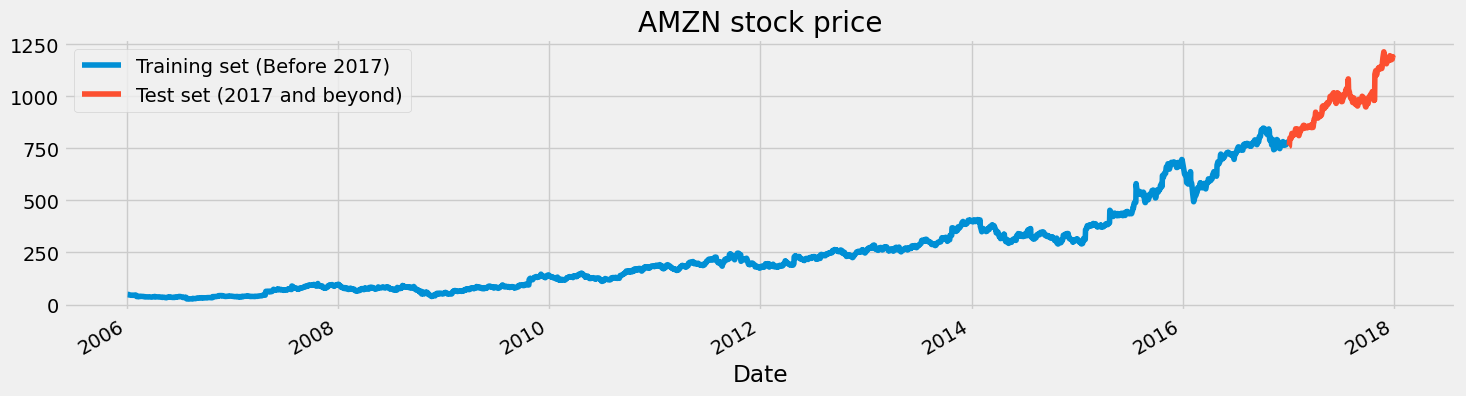

In [22]:

# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('AMZN stock price')
plt.show()

# Preprocessing the Data

In [23]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# Converting Inputs for RNN

In [24]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)

(2708, 60, 1)


# RNN Model

In [25]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=5, return_sequences=True, input_shape=(X_train.shape[1],1)))
# Second LSTM layer
regressor.add(LSTM(units=5))
# The output layer
regressor.add(Dense(units=1))
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=10,batch_size=32)

Train on 2708 samples
Epoch 1/10
2708/2708 [==============================] - 1s 526us/sample - loss: 0.0310
Epoch 2/10
2708/2708 [==============================] - 1s 375us/sample - loss: 9.5284e-04
Epoch 3/10
2708/2708 [==============================] - 1s 365us/sample - loss: 5.8028e-04
Epoch 4/10
2708/2708 [==============================] - 1s 357us/sample - loss: 5.0133e-04
Epoch 5/10
2708/2708 [==============================] - 1s 357us/sample - loss: 4.4815e-04
Epoch 6/10
2708/2708 [==============================] - 1s 356us/sample - loss: 4.3550e-04
Epoch 7/10
2708/2708 [==============================] - 1s 362us/sample - loss: 4.0671e-04
Epoch 8/10
2708/2708 [==============================] - 1s 358us/sample - loss: 4.0364e-04
Epoch 9/10
2708/2708 [==============================] - 1s 358us/sample - loss: 3.8871e-04
Epoch 10/10
2708/2708 [==============================] - 1s 352us/sample - loss: 3.6798e-04


# Preparing Data for Testing

In [26]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Evalutation and Testing

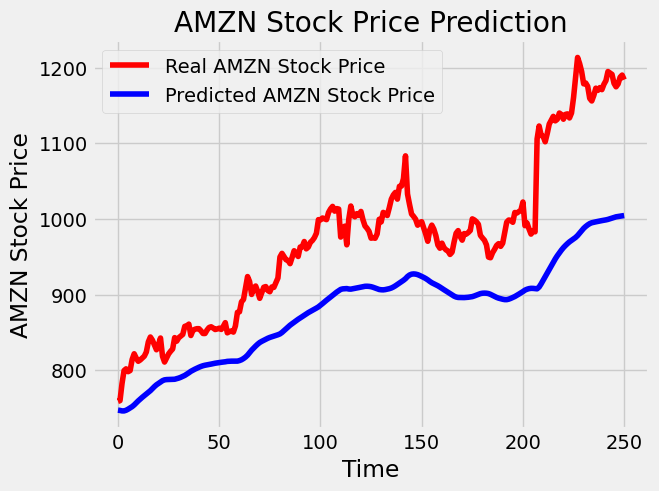

The root mean squared error is 105.88795179415649.


In [27]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real AMZN Stock Price')
    plt.plot(predicted, color='blue',label='Predicted AMZN Stock Price')
    plt.title('AMZN Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('AMZN Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

# Evaluating our model
return_rmse(test_set,predicted_stock_price)